In [1]:
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
from datetime import date, datetime, timedelta
import sqlalchemy
import pymysql
import openpyxl
import glob
from ast import literal_eval
from collections import Counter
from tqdm.auto import tqdm
import dask.dataframe as dd
import dask.array as da
import dask.bag as db
import pyarrow as pa
from dask.distributed import Client

In [ ]:
load_dotenv()

hyperlink_path = 'json_completed_hyperlinks_update.csv'
parent_dir = os.getenv('dir')
data_dir = os.path.join(parent_dir,'data_update')

df = pd.read_csv(hyperlink_path, header=None)
df.head()
df.columns = ['ParseID','Hyperlink']
hyperlinks = df['Hyperlink'].tolist()

def foldername(hyperlink):
    hyperlink = hyperlink.split('/')[-1]
    return hyperlink[0:-8]
def providers_path(folder):
    return os.path.join(data_dir,folder,folder+'_providers.csv')

folder_names= [foldername(hyperlink) for hyperlink in hyperlinks]
provider_files = [providers_path(folder_name) for folder_name in folder_names]

In [2]:
client = Client(n_workers=4)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 3.86 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50751,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 3.86 GiB
Comm: tcp://127.0.0.1:50790,Total threads: 1
Dashboard: http://127.0.0.1:50791/status,Memory: 0.96 GiB
Nanny: tcp://127.0.0.1:50755,


In [4]:
ddf = dd.read_parquet('D://Vignesh/Capstone/data_update/*/*_merge.parquet', 
                     columns=['billing_type','billing_code','negotiated_rates','ccn'], engine='pyarrow')

ddf


,billing_type,billing_code,negotiated_rates,ccn
npartitions=428,,,,
,object,object,float64,object
,...,...,...,...
...,...,...,...,...
,...,...,...,...
,...,...,...,...


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.410203 to fit


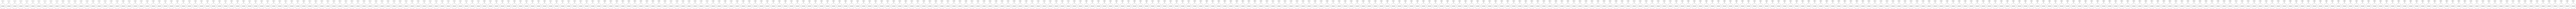

In [5]:
ddf.visualize()

In [6]:
ddf.drop_duplicates(ignore_index=True)
ddf.repartition(npartitions=428).to_parquet("D://Vignesh/Capstone/combined", 
                                         schema={'billing_type': pa.string(), 'billing_code': pa.string(),
                                                 'negotiated_rates': pa.float32(),'ccn': pa.string()},write_metadata_file=False)

ValueError: Failed to convert partition to expected pyarrow schema:
    `ArrowTypeError('Expected a string or bytes dtype, got int64', 'Conversion failed for column __null_dask_index__ with type int64')`

Expected partition schema:
    billing_type: string
    billing_code: string
    negotiated_rates: float
    ccn: string
    __null_dask_index__: string

Received partition schema:
    billing_type: string
    billing_code: string
    negotiated_rates: double
    ccn: string
    __null_dask_index__: int64

This error *may* be resolved by passing in schema information for
the mismatched column(s) using the `schema` keyword in `to_parquet`.